Let's look at our previous example of a nonlinear ODE:
$$
y'= y^2
$$
with $y(1)=-1$ with solution $y(t)=-\frac{1}{t}$. This is equivalent to following integral equation:
$$
y(t)= y(T) + \int_{T}^{t} y^{2}(s) ds
.
$$ 

To implement this we do slow recursion on $y(T)$ and fast recursion on the integral.

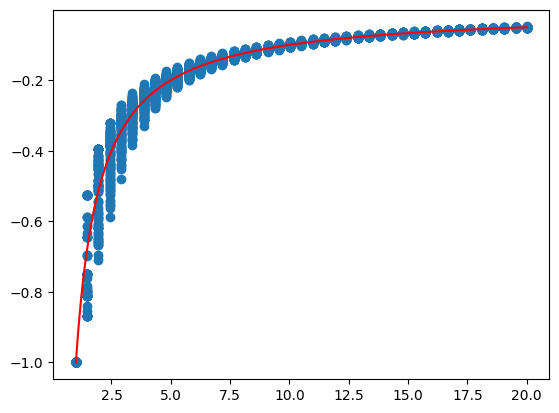

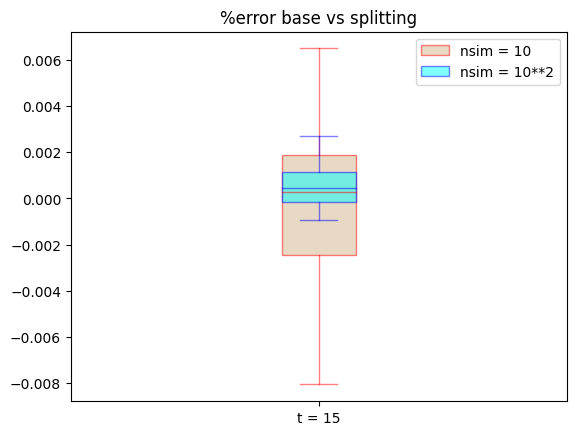

In [282]:
from random import random
import matplotlib.pyplot as plt
import numpy as np


def Y_fast(t, T, yT, DT):
    S = T + random()*(t-T)  # \sim Uniform(T,t)
    return yT + DT*Y_fast(S, T, yT, DT)*Y_fast(S, T, yT, DT) if random() < (t-T)/DT else yT


slow_points = []
def Y_slow(T, DT: "step size slow recursion"):
    TT = T-DT if T-DT > 1 else 1  # TT is where we are recursing to
    sol = Y_fast(T, TT, Y_slow(TT, DT), T-TT) if T > 1 else -1
    slow_points.append((T,sol))
    return sol


def pplot(T, n, nsim=10**2):
    s = sum(Y_slow(T, (T-1)/n) for _ in range(nsim))/nsim
    x,y = zip(*slow_points)
    xs = np.arange(1,T,0.01)
    z = [-1/l for l in xs]
    plt.scatter(x,y)
    plt.plot(xs,z,color = "red")
    plt.show()

pplot(20,40)

def split(T,DT,nsim=10**2):
    s= sum(Y_slow(T, DT) for _ in range(nsim))/nsim
    return (s+(1/T))*T

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, alpha = 0.5)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
    return bp

DT = 0.3
n= 50
ts= [15]
data = [[split(t,DT,nsim = 10) for _ in range(n)] for t in ts]
data1 = [[split(t,DT,nsim = 10**2) for _ in range(n)] for t in ts]

fig, ax = plt.subplots()
bp1 = box_plot(data, 'red', 'tan')
bp2 = box_plot(data1, 'blue', 'cyan')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nsim = 10', 'nsim = 10**2'])
plt.title("%error base vs splitting")
plt.xticks(ticks=[1],labels = [f"t = {t}" for t in ts])
#plt.ylim(-1,1)
plt.show()


The resulting estimator of RRMC is biased because the estimates in the inner recursion aren't independent ...